# Deep Learning Exercise: Transformers

In [30]:
import torch
from torch import nn
import random
import math
import numpy as np

# Set seed for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Exercise 1:  Scaled Dot-Product Attention

In this exercise, you will use PyTorch to implement the scaled dot product attention model. <br>


The equation in matrix form is as follows: 
$$\mathrm{Attention}(Q,K,V) =  \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

where $Q \in \mathbb{R}^{n \times d}$, $K \in \mathbb{R}^{m \times d}$, and $V \in \mathbb{R}^{m \times v}$. $d_k$ is the length of the input (query vector).<br>

Now it's time to implement this model in PyTorch. 


**Note**: For the **softmax** function, you can eaisly use the function [**nn.functional.softmax**](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html). 

In [31]:
class ScaledDotProductAttention(nn.Module):
  """Scaled dot product attention."""
  def __init__(self, **kwargs):
    super(ScaledDotProductAttention, self).__init__(**kwargs)
    self.attention_weights = None
    self.attention_output = None


  def forward(self, queries, keys, values):
    # plese write your code based on the above function
    # step 1: obtain d_k which is the length of the query vector
    d_k = len(queries) # YOUR CODE GOES HERE
    # step 2: calculate the attention weights
    self.attention_weights = nn.functional.softmax(queries@keys.transpose(0,1))/math.sqrt(d_k) # YOUR CODE GOES HERE
    # setp 3: get the output of the attention model -- multiply attention weights with values
    self.attention_output = torch.matmul(self.attention_weights, values) # YOUR CODE GOES HERE

    return self.attention_output

Given queries, keys and values, calculate the output of the scaled dot product attention model.

In [32]:
# queries, keys, values
queries = torch.normal(0, 1, (4, 8))
keys = torch.normal(0, 1, (6, 8))
values = torch.arange(30, dtype=torch.float32).reshape(6, 5)

# initialize the scaled dot product attention model
attention_model = ScaledDotProductAttention()
attention_model.eval()

# use the ScaledDotProductAttention class to get the results
scaled_dot_product_attention_output = attention_model(queries, keys, values)

print(scaled_dot_product_attention_output)

tensor([[ 8.9013,  9.4013,  9.9013, 10.4013, 10.9013],
        [ 9.6249, 10.1249, 10.6249, 11.1249, 11.6249],
        [ 6.7555,  7.2555,  7.7555,  8.2555,  8.7555],
        [10.5376, 11.0376, 11.5376, 12.0376, 12.5376]])


<ipython-input-31-21cab1da89f2>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.attention_weights = nn.functional.softmax(queries@keys.transpose(0,1))/math.sqrt(d_k) # YOUR CODE GOES HERE


# Exercise 2: Sentiment analysis using BERT
In this part, you will use the transformer-based model -- BERT to perfrom a ***sentiment analysis*** task based on the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/). <br>

Two important Python libraries will be used in this exercise:

*   [transformers](https://huggingface.co/transformers/): This one provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.
*   [torchtext](https://pytorch.org/text/stable/index.html): The torchtext package consists of data processing utilities and popular datasets for natural language.




In [ ]:
! pip install transformers
! pip install torchtext

## Set up GPU 
Check the availability of the GPU. Make sure you change the runtime type of the colab notebook to enable the use of the GPU. 

In [33]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Load and preprocess data

We will use the torchtext to load the IMDB dataset.<br>

Please refer to [the document of torchtext](https://https://pytorch.org/text/stable/datasets.html#imdb) for more information. <br>

**Note**: To make the training process less time-consuming, we extract 5000 IMDB reviews for the dataset.

In [34]:
from torchtext.datasets import IMDB

# get 5000 reviews with their sentiment labels
imdb_data =  list(IMDB(split='train'))
random.shuffle(imdb_data)

imdb_data = imdb_data[:int(0.2*len(imdb_data))]

ModuleNotFoundError: No module named 'torchtext'

Create a pandas DataFrame to visualize the dataset

In [ ]:
import pandas as pd

imdb_df = pd.DataFrame(imdb_data, columns=['sentiment', 'review'])

In [ ]:
# visualize the dataset
imdb_df

Use [pandas.DataFrame.replace](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) to convert the categorical values to numerical values for the **sentiment** column in the **imdb_df** DataFrame.


*   pos -> 1
*   neg -> 0




In [ ]:
# YOUR CODE GOES HERE

In [ ]:
# visualize the processed dataset
imdb_df

## Split the dataset to train/test sets

**Note**: The split ratio for train/test is 0.7/0.3

In [ ]:
# get reviews and corresponding sentiments from imdb_df
reviews = imdb_df.review.values
sentiments = imdb_df.sentiment.values

In [ ]:
from sklearn.model_selection import train_test_split

# use the function -- train_test_split to split the reviews and sentiments to get train/test sets

X_train, X_test, Y_train, Y_test = # YOUR CODE GOES HERE


# convert numpy array to list
X_train = X_train.tolist()
X_test = X_test.tolist()

## Preprocess data for the BERT model

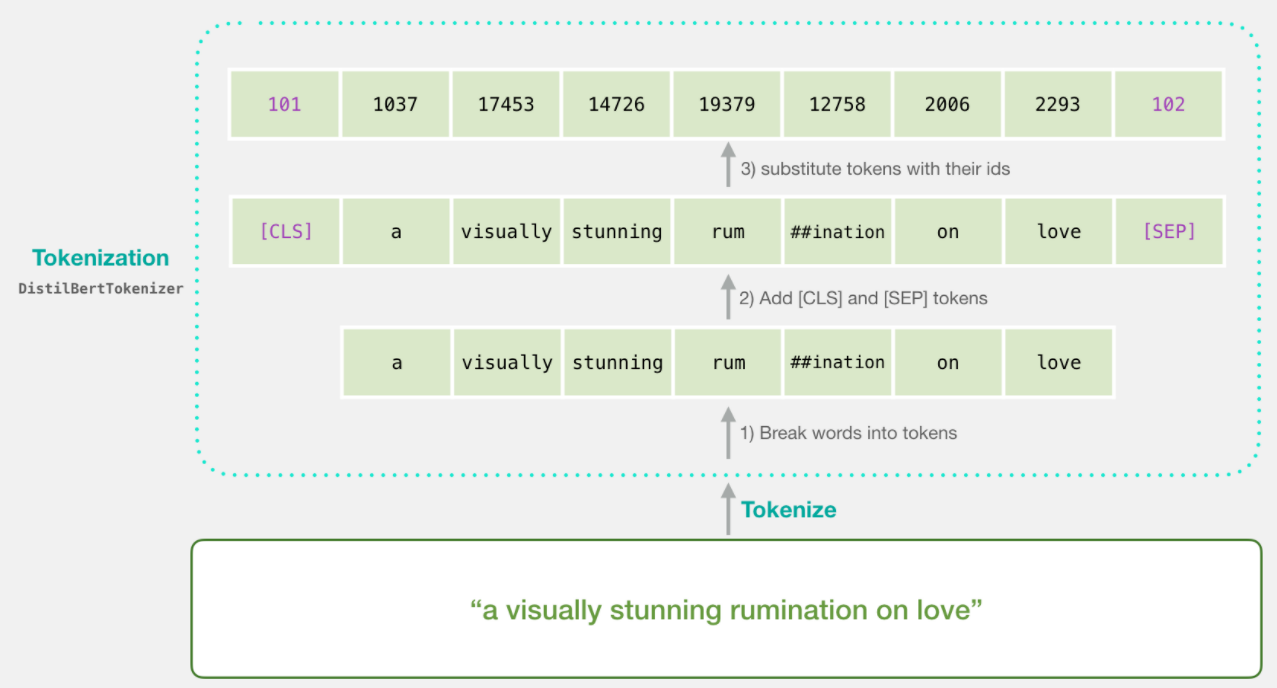

In order to use the pre-trained BERT model, we need to apply the **BERT tokenizer** to process the input sequence. <br>
The reasons are: 

1.   The model has a specific, fixed vocabulary. 
2.   The model uses the WordPiece tokenizer that has a particular way of handling out-of-vocabulary words.

Specifically, for the input sequence, we need to:


1.   add the special token `[CLS]` to the start, and the special token `[SEP]` to the end, for each sequence
2.   pad & truncate all sequences to a single constant length
3.   explicitly specify what are padding tokens with the "attention mask"

More information regarding the BERT tokenizer can be found [here](https://huggingface.co/transformers/tokenizer_summary.html).<br>

The above figure shows an example of how the tokenzier works. 




**Note**: Use `BertTokenizer` to tokenize the text in train and test sets. The output of the tokenizer is a dictionary string to list of ints. The output dictionary contains three keys: `input_ids`, `attention_mask`, and `token_type_ids`.
The `input_ids` are the indices corresponding to each token in our 

*   The `input_ids` are the indices corresponding to each token in our sentence. 
*   The `attention_mask` points out which tokens the model should pay attention to and which ones it should not (since some of the tokens are padding tokens). 
*   The `token_type_ids` indicates to the model which part of the inputs correspond to the first sentence and which part corresponds to the second sentence. In our case, it will have values of all zeros.

Check this [link](https://huggingface.co/transformers/preprocessing.html) to see how to use the tokenizer.


In [ ]:
from transformers import BertTokenizer

# load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# use the tokenizer to tokenize X_train and X_test to get the input_ids, token_type_ids, and attention_mask
# set padding and truncation to True, return_tensors to 'pt', and max_length to 100
# the data type of the tokenizer_output_train and the tokenizer_output_test is dictionary

tokenizer_output_train = # YOUR CODE GOES HERE
tokenizer_output_test = # YOUR CODE GOES HERE

## Create PyTorch DataLoader

Use the torch [DataLoader](https://pytorch.org/docs/stable/data.html) class to create iterators for the train and test sets. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# convert the data type of the train and test labels to torch.tensor
train_labels = torch.tensor(Y_train)
test_labels = torch.tensor(Y_test)

# set the batch_size for training and testing
train_batch_size = 32
test_batch_size = 64

# create the DataLoader for the train set
train_data = TensorDataset(tokenizer_output_train['input_ids'], tokenizer_output_train['attention_mask'], tokenizer_output_train['token_type_ids'], train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = # YOUR CODE GOES HERE, use train_batch_size

# create the DataLoader for the test set
test_data = TensorDataset(tokenizer_output_test['input_ids'], tokenizer_output_test['attention_mask'], tokenizer_output_test['token_type_ids'], test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = # YOUR CODE GOES HERE, use test_batch_size

## Build our BERT model for sentiment analysis

### Create BertClassifier

BERT-base consists of 12 transformer encoder layers, each encoder layer takes in a list of token embeddings, and produces the same number of embeddings with a same hidden size on the output. The output of the final encoder layer of the `[CLS]` token is used to classifiy the input sequence.<br>

We will create a `BertClassifier` class that is based on the `bert-base-uncased` model to use the last hidden layer of the `[CLS] `token and a single-hidden-layer feed-forward neural network as our classifier.

**Note**: 

1.   check this [link](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) for the output of the BertModel. 
2.   check [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) for how to build a single-hidden-layer feed-forward neural network. You can use [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Make sure you use the correct dimensions of the network as mentioned in the code below.



In [ ]:
from transformers import BertModel
bert1 = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
from transformers import BertModel

# create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for sentiment analysis.
    """
    def __init__(self):
        """
        @param  hidden_size_classifier (int): the hidden size of the classifier
        """
        super(BertClassifier, self).__init__()

        # instantiate the BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # specify hidden size of BERT, hidden size of our classifier, and number of labels
        self.hidden_size_bert = self.bert.config.hidden_size
        self.hidden_size_classifier = 50
        self.num_labels = 2

        # instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            # YOUR CODE GOES HERE
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size, max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask information with shape (batch_size, max_length)
        @param    token_type_ids (torch.Tensor): a tensor that hold token type information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids
                            )
        
        # extract the last hidden state of the token `[CLS]` for sentence classification
        # outputs is a tuple of (last_hidden_state, pooler_output)
        # use the last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)) to get the hidden state of the [CLS] token
        last_hidden_state_cls = # YOUR CODE GOES HERE

        # feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### Optimizer and Loss Function



*   For the optimizer, use the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html). Recommended learning rate : 5e-5, 3e-5 or 2e-5. Recommended eps: 1e-8.
*   For the loss function (criterion), use the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).




In [ ]:
from transformers import AdamW

# instantiate a Bert Classifier
bert_classifier = BertClassifier()

# move the model to device (GPU or CPU)
bert_classifier.to(device)

# create the optimizer
optimizer = # YOUR CODE GOES HERE

# set the loss function
criterion = # YOUR CODE GOES HERE

### Training

The training loop involves the following steps:


*   Unpack our data from the dataloader and load the data onto the GPU
*   Zero out gradients calculated in the previous pass
* Perform a forward pass to compute logits and loss
* Perform a backward pass to compute gradients
* Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
* Update the model's parameters 
* Update the learning rate 



In [ ]:
from transformers import get_linear_schedule_with_warmup
import time

# training loop
def train(dataloader, model, optimizer, criterion, epochs):

  # set the scheduler
  total_steps = len(dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  print('Start training...\n')
  for epoch_i in range(epochs):
    
      # print the header of the result table
      print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Elapsed':^9}")
      print("-"*70)

      # measure the elapsed time of each epoch
      t0_epoch, t0_batch = time.time(), time.time()

      # reset tracking variables at the beginning of each epoch
      total_loss, batch_loss, batch_counts = 0, 0, 0

      # put the model into the training mode
      model.train()

      # for each batch of training data...
      for step, batch in enumerate(train_dataloader):
          batch_counts +=1
          # load batch to device (GPU or CPU)
          b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

          # zero out any previously calculated gradients
          model.zero_grad()

          # perform a forward pass. This will return logits.
          # use b_input_ids, b_attn_mask, b_token_type_ids to input to the model
          logits = # YOUR CODE GOES HERE

          # compute loss and accumulate the loss values
          loss = criterion(logits, b_labels)
          batch_loss += loss.item()
          total_loss += loss.item()

          # perform a backward pass to calculate gradients
          # use backward() function for the loss
          # YOUR CODE GOES HERE

          # clip the norm of the gradients to 1.0 to prevent "exploding gradients"
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # update parameters and the learning rate
          optimizer.step()
          scheduler.step()

          # print the loss values and time elapsed for every 20 batches
          if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
              # calculate time elapsed for 20 batches
              time_elapsed = time.time() - t0_batch

              # print training results
              print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

              # reset batch tracking variables
              batch_loss, batch_counts = 0, 0
              t0_batch = time.time()

      # calculate the average loss over the entire training data
      avg_train_loss = total_loss / len(train_dataloader)

  print('Training complete')

In [ ]:
train(train_dataloader, bert_classifier, optimizer, criterion, epochs = 2)

### Evaluation 

The steps for evaluation are:

*   Unpack our data and load onto the GPU
*   Forward pass
*   Compute the f1 score over the test set

**Note**: check [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) for the use of `sklearn.metrics.f1_score`

In [ ]:
from sklearn.metrics import f1_score

# evaluation 
def evaluate(model, dataloader):
  # put the model into the evaluation mode. The dropout layers are disabled during the test time.
  model.eval()

  # tracking variables
  predictions = []
  labels = []

  # for each batch in our validation set...
  for batch in dataloader:
      # load batch to GPU
      b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

      # compute logits
      with torch.no_grad():
          logits = model(b_input_ids, b_attn_mask, b_token_type_ids)

      # get the predictions
      preds = torch.argmax(logits, dim=1).flatten()
      predictions.append(preds.detach().cpu().numpy())

      # get the labels
      labels.append(b_labels.detach().cpu().numpy())

  # get two lists of predictions and labels with 1d array
  predictions = np.concatenate(predictions, axis=0)
  labels = np.concatenate(labels, axis=0)

  # calc the f1 score using f1_score between predictions and labels
  f1 = # YOUR CODE GOES HERE

  return f1

In [ ]:
score = evaluate(bert_classifier, test_dataloader)

In [ ]:
print('The f1 score for the test set is {0:4.2f}%'.format(score*100) )

### Prediction

In this part, you will use the fine-tuned `bert_classifier` to predict the sentiment of a given review from the IMDB dataset.

In [ ]:
# Get one sample from IMDB
instance = list(IMDB(split='test'))[10]

In [ ]:
sentiment, review = instance

In [ ]:
print(f'The review text is: \n {review}')

In [ ]:
print(f'The sentiment of the review text is: \n {sentiment}')

In [ ]:
# tokenize the review text
output_tokenizer = tokenizer(review)

# convert the tokenizer results to torch.tensor and send to the device(GPU)
p_input_ids = torch.tensor(output_tokenizer['input_ids']).unsqueeze(0).to(device)
p_attention_mask = torch.tensor(output_tokenizer['attention_mask']).unsqueeze(0).to(device)
p_token_type_ids = torch.tensor(output_tokenizer['token_type_ids']).unsqueeze(0).to(device)

# get the model output, refer to the evaluate function for help
logits = # YOUR CODE GOES HERE
prediction = # YOUR CODE GOES HERE

# get the label
prediction = 'neg' if prediction==0 else 'pos'
print(f'The predicted sentiment is {prediction}, the true sentiment is {sentiment}.')

# Exercise 3: Visualize Attention in the BERT model

Use **[BertViz](https://github.com/jessevig/bertviz)** to visualize the attention patterns produced by one or more attention heads in a BERT layer.

**Note**: check [here](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel.forward) for how to get attention from BertModel.

In [ ]:
!pip install bertviz

In [ ]:
from bertviz import head_view

# Load model and retrieve attention
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
# input the model with input_ids and toekn_type_ids to get the attention
attention = # YOUR CODE GOES HERE
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [ ]:
head_view(attention, tokens)